In [1]:
from my_autograd import *

In [2]:
l1 = Variable(2)
l2 = Variable(3)
r = plus(l1,l2)
print(l1,l2,r)
backward_graph(r)
print(l1.grad,l2.grad,r.grad)

Variable(id:0,prev:[],is_leaf:True)
 Variable(id:1,prev:[],is_leaf:True)
 Variable(id:2,prev:[0, 1],is_leaf:False)

[1.] [1.] [1.]


In [3]:
l1 = Variable(4)

n1 = relu(l1)
# print(c,d)
# t_sort = top_sort(d)
# print(t_sort)
print(n1)
backward_graph(n1)
print(l1.grad,n1.grad)

Variable(id:4,prev:[3],is_leaf:False)

[1.] [1.]


In [4]:
l1 = Variable(2)
l2 = Variable(3)

n1 = c_mul(l1,2)
n2 = plus(n1,l2)
n3 = dot(n2,n2)
# print(c,d)
# t_sort = top_sort(d)
# print(t_sort)
print(l1,l2,n1,n2,n3)
backward_graph(n3)
print(l1.grad,l2.grad,n1.grad,n2.grad,n3.grad)

Variable(id:5,prev:[],is_leaf:True)
 Variable(id:6,prev:[],is_leaf:True)
 Variable(id:7,prev:[5],is_leaf:False)
 Variable(id:8,prev:[7, 6],is_leaf:False)
 Variable(id:9,prev:[8, 8],is_leaf:False)

[28.] [14.] [14.] [14.] [1.]


In [5]:
l1 = Variable(np.arange(-4,4).reshape(2,4))
l2 = Variable(np.arange(-2,2).reshape(4,1))

n1 = dot(l1,l2)
n2 = relu(n1)
n3 = sumel(n2)
print(n3)
backward_graph(n2)
print(l1.grad)
print(l2.grad)

Variable(id:14,prev:[13],is_leaf:False)

[[-2. -1.  0.  1.]
 [-2. -1.  0.  1.]]
[[-4.]
 [-2.]
 [ 0.]
 [ 2.]]


## Linear Regression

In [131]:
from setup_problem import load_problem
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')


In [136]:
import time
w = Variable(np.random.uniform(-1/400,1/400,(400,1)))
n_step = 5000
lr =5e-3
l2reg = 0


start = time.monotonic()
for i in range(n_step):
    x = Variable(featurize(x_train))
    y = Variable(y_train.reshape(100,1))
    predictions = dot(x,w)
    residual = minus(y, predictions)
    empirical_risk = c_mul(sumel(multiply(residual,residual)),1.0/100)
    l2_norm_squared = c_mul(sumel(multiply(w,w)),l2reg)
    loss = plus(empirical_risk,l2_norm_squared)
    w.zero_grad()
    backward_graph(loss)
    
    if i%(int(n_step/min(10,n_step)))==0: 
        print(loss.data[0])
        
    w.step(lr)

print(f'Time per batch:{(time.monotonic()-start)*1000/n_step} ms')


3.5631292725294252
0.10691890056808134
0.08476057731676243
0.07273423521845365
0.06451572506326587
0.05829496565983302
0.053332149877928885
0.04924352262692321
0.04579724975077387
0.042840239058586
Time per batch:2.4902015788000424 ms


In [137]:
n_hidden = 1000
x_trainf = featurize(x_train)

class Net():
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = LinearLayer(400,n_hidden)
        self.fc2 = LinearLayer(n_hidden,1)

    def forward(self, inp):
#         import pdb; pdb.set_trace()
        n1 = relu(self.fc1.forward(inp))
        return self.fc2.forward(n1)
    
    def zero_grad(self):
        self.fc1.zero_grad()
        self.fc2.zero_grad()
        
    def step(self,lr):
        self.fc1.step(lr)
        self.fc2.step(lr)

model = Net()


In [138]:
n_hidden = [1000,100]
x_trainf = featurize(x_train)

class Net():
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = LinearLayer(1,n_hidden[0])
        self.fc2 = LinearLayer(n_hidden[0],n_hidden[1])
        self.fc3 = LinearLayer(n_hidden[1],1)

    def forward(self, inp):
#         import pdb; pdb.set_trace()
        n1 = relu(self.fc1.forward(inp))
        n2 = relu(self.fc2.forward(n1))
        return self.fc3.forward(n2)
    
    def zero_grad(self):
        self.fc1.zero_grad()
        self.fc2.zero_grad()
        self.fc3.zero_grad()
        
    def step(self,lr):
        self.fc1.step(lr)
        self.fc2.step(lr)
        self.fc3.step(lr)

model = Net()


In [139]:
import time
n_step = 1000
lr =1e-2

start = time.monotonic()
for i in range(n_step):
    a=Variable(x_train.reshape(100,1))
    b=Variable(y_train.reshape(100,1))
    out = model.forward(a)
    residual = minus(out,b)
    loss = c_mul(sumel(multiply(residual,residual)),1.0/100)
    model.zero_grad()
    backward_graph(loss)
    
    if i%(int(n_step/min(10,n_step)))==0: 
        print(loss.data[0])
        
    model.step(lr)

print(f'Time per batch:{(time.monotonic()-start)*1000/n_step} ms')

3.6094181953956235
0.7450593830438155
0.7003549868196897
0.62852463367955
0.7882718082956488
0.7268501087770817
0.519834209968031
0.5122131867490793
0.6915400739555334
0.5153112963492469
Time per batch:9.174216180996154 ms


In [193]:
import torch
from torch import autograd
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
lr = 1e-3
n_step = 5000
n_hidden = [100,100]
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden[0])
        self.bn1 = nn.BatchNorm1d(n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.bn2 = nn.BatchNorm1d(n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], 1)

    def forward(self, x):
#         self.mem = F.relu(self.fc1(x))
#         return self.fc2(F.relu(self.fc1(x)))
        return self.fc3(self.bn2(F.relu(self.fc2(self.bn1(F.relu(self.fc1(x)))))))
    
model2 = Net2()

optimizer = optim.Adam(model2.parameters(), lr=lr)

start = time.monotonic()

for i in range(n_step):
    a=autograd.Variable(torch.from_numpy(x_train).view(100,1).float(), requires_grad=False)
    b=autograd.Variable(torch.from_numpy(y_train.reshape(100,1)).float())
    out = model2(a)
    loss = (out-b).pow(2).sum()/100
    if i%(int(n_step/min(10,n_step)))==0: 
        print(f'loss: {loss.data[0]}')
#         print(a,out,b)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f'Time per batch:{(time.monotonic()-start)*1000/n_step} ms')

loss: 3.813589096069336
loss: 0.07339849323034286
loss: 0.07126876711845398
loss: 0.0654313787817955
loss: 0.0579523928463459
loss: 0.0591767318546772
loss: 0.04935906454920769
loss: 0.04827651008963585
loss: 0.0496123731136322
loss: 0.046924442052841187
Time per batch:2.474570830599987 ms


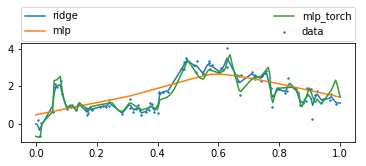

In [194]:
import matplotlib.pyplot as plt
# Data for plotting
t = np.linspace(0,1,200)
x = Variable(t.reshape(200,1))
x_ridge = Variable(featurize(t))
x_torch = autograd.Variable(torch.from_numpy(t.reshape(200,1)).float())
ridge = dot(x_ridge,w).data
mlp = model.forward(x).data
mlp_torch = model2(x_torch).data.numpy()
# s = model.forward(inpp).data[:,0]
# s2 = model2(autograd.Variable(torch.from_numpy(inpp.data).float())).data.numpy()[:,0]
# s3 = np.sin(t)

plt.subplot(211)
# print(s.shape,s2.shape,s3.shape)
plt.scatter(x_train,y_train, label="data",s=2)
plt.plot(t,ridge, label="ridge")
plt.plot(t,mlp, label="mlp")
plt.plot(t,mlp_torch, label="mlp_torch")
# plt.scatter(x_train,model2.mem[:,0].data.numpy(), label="mlp_unit0",s=2)
# plt.scatter(x_train,model2.mem[:,1].data.numpy(), label="mlp_unit1",s=2)
# plt.scatter(x_train,model2.mem[:,9].data.numpy(), label="mlp_unit9",s=2)


plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.show()
